In [1]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 5.1 MB/s 


In [2]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Concatenate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle5 as pickle
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
import tensorflow as tf
seed=2022
tf.random.set_seed(seed)
np.random.seed(seed)

## 기타 데이터 가공

In [4]:
df2=pd.read_csv('/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/test_df_15세65세_aug전.csv')
df2

,uuid,cough_detected,SNR,gender,man,respiratory_condition,fever_muscle_pain,COVID-19,healthy,symptomatic,15세미만,15세이상65세미만,65세이상
0,045364d1-30c3-4784-a51f-48f791b913a1,0.9921,13.398699,male,1,1,0,0,1,0,0,1,0
1,045daa57-6df5-4bf9-86dd-eb1c3876c01f,0.0453,10.697848,male,1,1,0,0,1,0,0,1,0
2,045fd90f-c1ba-42e9-abda-2a85a9514377,0.9309,14.887904,male,1,0,0,0,1,0,0,1,0
3,046545bc-7f2c-4425-9be2-ffc22bba515e,1.0000,4.939982,male,1,0,0,0,1,0,0,1,0
4,046b583a-7775-4bd2-a3e6-63e81f10959b,0.7523,35.782015,male,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
515,f5231767-4f81-4b7a-bace-c6eae80fe56c,1.0000,10.065814,female,0,0,1,1,0,0,0,1,0
516,f6ffd0b9-8708-4a79-ba7c-1557df8ac814,1.0000,9.421140,female,0,0,0,1,0,0,0,1,0
517,f7c0a229-049b-49cb-a6f3-ad2b0e7bb90d,1.0000,14.984980,female,0,0,0,1,0,0,0,1,0
518,f7c229bd-ed49-40d5-a1bc-837ea7b66bd0,1.0000,12.541848,female,0,0,1,1,0,0,0,1,0


In [12]:
X2=df2.iloc[:, [4,5,6,7]]

In [13]:
X2

,man,respiratory_condition,fever_muscle_pain,COVID-19
0,1,1,0,0
1,1,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
515,0,0,1,1
516,0,0,0,1
517,0,0,0,1
518,0,0,1,1


## 음성 데이터 가공

In [14]:
with open("/content/drive/MyDrive/멀캠_2nd_semiproject/데이터/test/fffff.pickle","rb") as fr:
    data = pickle.load(fr)

length=[]
for i in range(len(data)):
    length.append(data[i].shape[1])
    
min_len=min(length)

result=[]
for i in range(len(data)):
    result.append(data[i][:,:min_len])
    
result_data=np.array(result)

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(
    result_data, X2, stratify = X2, test_size = 0.2
)

In [16]:
features_train = Y_train.iloc[:,:-1].values
y_data_train = Y_train.iloc[:,-1].values
features_test = Y_test.iloc[:,:-1].values
y_data_test = Y_test.iloc[:,-1].values

In [17]:
img_input=Input(shape=(30,901,1), name='cough_sound')
other_input=Input(shape=(3), name='other_data')

# 기침 데이터 처리 모델 구현
x_1=Conv2D(256, kernel_size=(3,3), activation='relu')(img_input)
x_1=Conv2D(256, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Dropout(0.25)(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=Conv2D(128, (3,3), activation='relu')(x_1)
x_1=MaxPooling2D()(x_1)
x_1=Flatten()(x_1)
x_1=Dense(128, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)
x_1=Dense(64, activation='relu')(x_1)
x_1=Dropout(0.5)(x_1)

x_2=Dense(128, activation='relu')(other_input)
x_2=Dense(52, activation='relu')(x_2)

x=Concatenate()([x_1,x_2])
x_3=Dense(128, activation='relu')(x)
result=Dense(1, activation='sigmoid', name='test_result')(x_3)

model = Model([img_input,other_input], result)

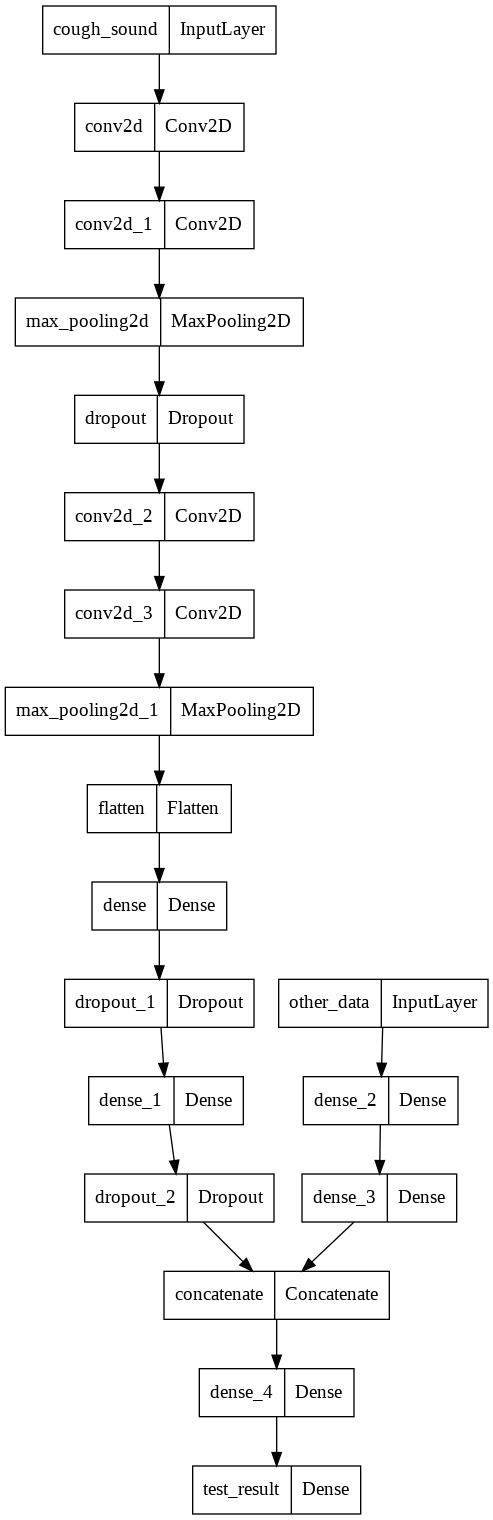

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [19]:
model_path='best-covid-complex_young.h5'
mc=ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
es=EarlyStopping(patience=10)

In [20]:
model.compile('adam', loss=['binary_crossentropy'], metrics={'test_result':'acc'})

hist=model.fit(
    [X_train, features_train], y_data_train, validation_split=0.2, epochs=50, batch_size=50, callbacks=[mc, es]
)

Epoch 1/50
7/7 [==============================] - ETA: 0s - loss: 2.9526 - acc: 0.5271
Epoch 1: val_loss improved from inf to 0.69693, saving model to best-covid-complex_young.h5
7/7 [==============================] - 35s 2s/step - loss: 2.9526 - acc: 0.5271 - val_loss: 0.6969 - val_acc: 0.4524
Epoch 2/50
7/7 [==============================] - ETA: 0s - loss: 0.6866 - acc: 0.5422
Epoch 2: val_loss improved from 0.69693 to 0.68189, saving model to best-covid-complex_young.h5
7/7 [==============================] - 7s 1s/step - loss: 0.6866 - acc: 0.5422 - val_loss: 0.6819 - val_acc: 0.4881
Epoch 3/50
7/7 [==============================] - ETA: 0s - loss: 0.6766 - acc: 0.5843
Epoch 3: val_loss did not improve from 0.68189
7/7 [==============================] - 6s 904ms/step - loss: 0.6766 - acc: 0.5843 - val_loss: 0.6931 - val_acc: 0.4524
Epoch 4/50
7/7 [==============================] - ETA: 0s - loss: 0.6700 - acc: 0.5783
Epoch 4: val_loss did not improve from 0.68189
7/7 [=============

In [21]:
best_model=load_model(model_path)
best_model.evaluate([X_test, features_test], y_data_test,)

4/4 [==============================] - 2s 439ms/step - loss: 0.6612 - acc: 0.5769


[0.6612450480461121, 0.5769230723381042]

In [22]:
from sklearn.metrics import confusion_matrix
y_train_pred=best_model.predict([X_test, features_test])
yhat=[]
for data in y_train_pred:
  if data>=0.5:
    yhat.append(1)
  else:
    yhat.append(0)
print(yhat)

[0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]


In [23]:
cf = confusion_matrix(y_data_test, yhat)
print(cf)

[[38 14]
 [30 22]]


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score
p = precision_score(y_data_test, yhat)
print(p)
r = recall_score(y_data_test, yhat)
print(r)
f1 = f1_score(y_data_test, yhat)
print(f1)

0.6111111111111112
0.4230769230769231
0.5
